In [3]:
from src.tools import MMSeqs, Prodigal
import pandas as pd
import numpy as np
from src.files import XMLFile, InterProScanFile, FASTAFile, GBFFFile
from utils import * 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from src.clusterer import Clusterer
from src.dataset import Dataset, Pruner
import torch
import seaborn as sns 
from src import get_genome_id
import re
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import glob
import subprocess
from src.tools.prodigal import remove_asterisks

%load_ext autoreload 
%autoreload 2

# TODO: Do AntiFam sequences with the same annotation cluster together?

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# remove_asterisks(*glob.glob('../data/prodigal/*'))

In [5]:
genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)
genome_ids = genome_metadata_df[genome_metadata_df.phylum == 'Campylobacterota'].index.values 

for path in tqdm(glob.glob('../data/prodigal/*'), desc='Running InterProScan'):
    genome_id = get_genome_id(path)
    output_path = f'../data/interpro/{genome_id}_annotation.tsv'
    if not os.path.exists(output_path):
        cmd = f'~/interproscan/interproscan-5.73-104.0/interproscan.sh -i {path} -o {output_path} -f tsv'
        subprocess.run(cmd, shell=True, check=True)


Running InterProScan: 100%|██████████| 197/197 [00:00<00:00, 55697.87it/s]


In [ ]:
def alignment_to_distances(path:str, index:np.ndarray=None, col:str='sequence_identity') -> pd.DataFrame:
    # Convert the alignment data to a distance matrix. 
    align_df = MMSeqs.load_align(path)
    df = pd.DataFrame(index=index, columns=index) 
    for row in tqdm(align_df.itertuples(), total=len(align_df)):
        df.loc[row.Index, row.subject_id] = getattr(row, col)
        df.loc[row.subject_id, row.Index] = getattr(row, col)
    with pd.option_context('future.no_silent_downcasting', True):
        df = df.fillna(0.0)
    return df

dataset = Dataset.from_hdf('../data/dataset_subset.h5', feature_type='esm_650m_gap', attrs=['label', 'genome_id'])
dataset_df = pd.read_csv('../data/dataset_subset.csv', index_col=0)
# dists = pairwise_distances(StandardScaler().fit_transform(dataset.numpy()), metric='euclidean')
# dists_df = pd.DataFrame(dists, index=dataset.index, columns=dataset.index)
# dists_df.to_csv('../data/dataset_subset_dists.csv')
dists_df = pd.read_csv('../data/dataset_subset_dists.csv', index_col=0)

# MMSeqs().align(dataset_df, name='dataset_subset', output_dir='../data', sensitivity=10, max_e_value=10, overwrite=False)
# align_df = alignment_to_distances('../data/dataset_subset_align.tsv', index=dists_df.index)
# align_score_df = alignment_to_distances('../data/dataset_subset_align.tsv', index=dists_df.index, col='bit_score')

figure: Number of instances where a real sequence is a better distance match than another spurious sequence: 14
figure: Best distance between spurious and real: 20.039746783867507
figure: Best distance between two spurious: 1.7031034302649029


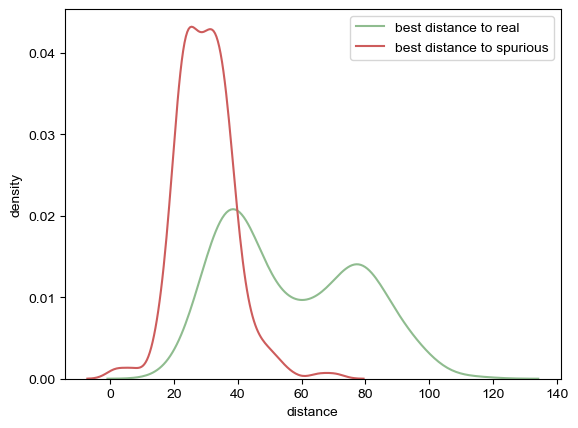

In [ ]:
def figure(df, dataset, metric:str='alignment'):

    func = np.min if (metric == 'distance') else np.max 
    fill_value = np.inf if (metric == 'distance') else 0
    compare = np.less if (metric == 'distance') else np.greater

    real_ids = dataset.index[dataset.label == 1]
    spurious_ids = dataset.index[dataset.label == 0]

    metric_to_spurious = df.loc[spurious_ids, spurious_ids].values
    np.fill_diagonal(metric_to_spurious, fill_value)
    metric_to_spurious = func(metric_to_spurious, axis=1)

    metric_to_real = df.loc[spurious_ids, real_ids].values
    metric_to_real = func(metric_to_real, axis=1)

    print(f'figure: Number of instances where a real sequence is a better {metric} match than another spurious sequence: {compare(metric_to_real, metric_to_spurious).sum()}')
    print(f'figure: Best {metric} between spurious and real: {func(metric_to_real)}')
    print(f'figure: Best {metric} between two spurious: {func(metric_to_spurious)}')

    fig, ax = plt.subplots()

    sns.kdeplot(ax=ax, x=metric_to_real.ravel(), color='darkseagreen', label=f'best {metric} to real')
    sns.kdeplot(ax=ax, x=metric_to_spurious.ravel(), color='indianred', label=f'best {metric} to spurious')
    ax.legend()

    ax.set_ylabel('density')
    ax.set_xlabel(metric)

    plt.show()

figure(dists_df, dataset, metric='distance')

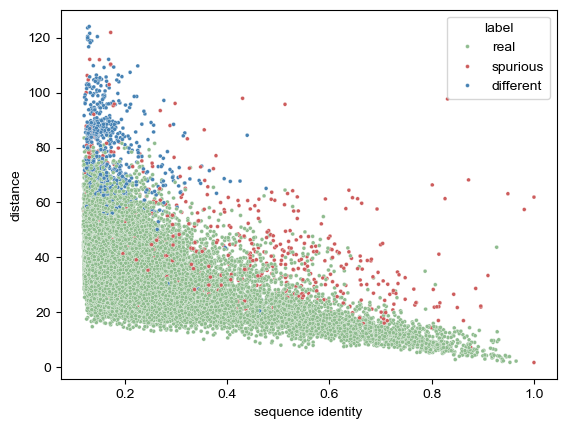

In [ ]:
def figure(dataset_df, align_df, dists_df, x_label:bool='bit_score'):
    fig, ax = plt.subplots()
    
    # idxs = np.triu_indices(n=5000, k=1)

    align_arr = np.tril(align_df.values, k=-1) # Avoid plotting the same pair twice. 
    dist_arr = np.tril(dists_df.values) # Avoid plotting the same pair twice. 
    n = dists_df.shape[0]

    labels = np.array(['spurious' if (label == 0) else 'real' for label in dataset_df.label])
    labels = np.tile(labels, (n, 1))
    labels = np.where(labels == labels.T, labels, 'different') # Mark locations where the labels are different. 

    ax_df = dict()
    ax_df['label'] = labels[align_arr > 0]
    ax_df[x_label] = align_arr[align_arr > 0]
    ax_df['distance'] = dist_arr[align_arr > 0]
    ax_df = pd.DataFrame(ax_df)

    hue_order = ['real', 'spurious', 'different']
    colors = ['darkseagreen', 'indianred', 'steelblue']
    # colors = {'real':'darkseagreen', 'spurious':'indianred', 'different':'steelblue'}
    sns.scatterplot(data=ax_df, x=x_label, y='distance', hue='label', hue_order=hue_order, palette=colors, ax=ax, s=8)
    sns.move_legend(ax, loc='upper right')

    ax.set_xlabel(x_label.replace('_', ' '))
    ax.set_ylabel('distance')
    # ax.set_xlim(xmin=1500)
    # ax.set_ylim(ymax=20)

    plt.show()

# figure(dataset_df, align_score_df, dists_df)
figure(dataset_df, align_df, dists_df, x_label='sequence_identity')


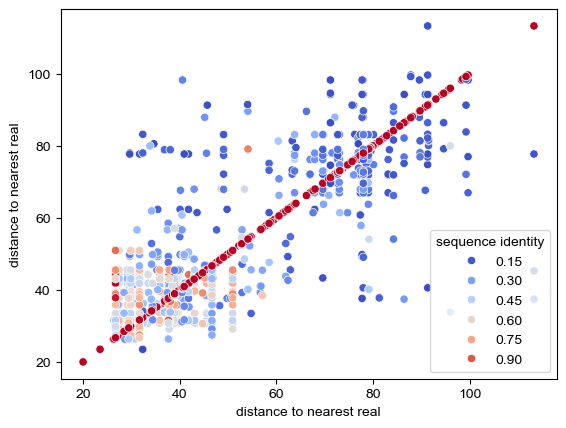

In [ ]:
def figure(dataset_df, align_df, dists_df, min_sequence_identity:float=0.1):
    fig, ax = plt.subplots()

    labels = dataset_df.label.values 
    spurious_ids = dataset_df[labels == 0].index
    
    dists_to_real = dists_df.loc[labels == 0, labels == 1].min(axis=1)
    # dists_to_real = dists_df.loc[labels == 1, labels == 0].mean(axis=1)
    
    align_arr = np.tril(align_df.loc[spurious_ids, spurious_ids].values)
    idxs = np.where(align_arr > min_sequence_identity)

    ax_df = pd.DataFrame()
    ax_df['dist_x'] = dists_to_real.values[idxs[0]]
    ax_df['dist_y'] = dists_to_real.values[idxs[1]]
    ax_df['sequence_identity'] = align_arr[idxs] # .ravel()
    sns.scatterplot(data=ax_df, x='dist_x', y='dist_y', ax=ax, palette='coolwarm', hue='sequence_identity')

    ax.legend().set_title('sequence identity')
    ax.set_ylabel('distance to nearest real')
    ax.set_xlabel('distance to nearest real')
    # ax.set_xlim(1, 3)
    # ax.set_ylim(1, 3)
    plt.show()


figure(dataset_df, align_df, dists_df)
# Why would there be cases where one sequence's distance to a real sequence is the same as another's?
# Is this related to the fact that I used lower-precision floats?
# Are there any cases where the embeddings are the same but the sequences are different?

In [33]:
clusterer = Clusterer(n_clusters=1000)
clusterer.fit(dataset)

Clusterer.fit: Split 0, cluster 0 divided using bisection strategy largest_non_homogenous.
Clusterer.fit: Split 1, cluster 0 divided using bisection strategy largest_non_homogenous.
Clusterer.fit: Split 2, cluster 0 divided using bisection strategy largest_non_homogenous.
Clusterer.fit: Split 3, cluster 3 divided using bisection strategy largest_non_homogenous.
Clusterer.fit: Split 4, cluster 2 divided using bisection strategy largest_non_homogenous.
Clusterer.fit: Split 5, cluster 3 divided using bisection strategy largest_non_homogenous.
Clusterer.fit: Split 6, cluster 4 divided using bisection strategy largest_non_homogenous.
Clusterer.fit: Split 7, cluster 6 divided using bisection strategy largest_non_homogenous.
Clusterer.fit: Split 8, cluster 5 divided using bisection strategy largest_non_homogenous.
Clusterer.fit: Split 9, cluster 7 divided using bisection strategy largest_non_homogenous.
Clusterer.fit: Split 10, cluster 7 divided using bisection strategy largest_non_homogenous

/home/prichter/Documents/frugal/src/clusterer.py:130: UserWarning: Clusterer.fit: There are 0 remaining clusters which are not homogenous.
  


In [34]:
clusterer.tree

'((((((((((0, 976), (407, ((620, 826), 784))), ((55, 911), (74, (86, (95, (110, (121, 140))))))), (45, ((409, 761), 548))), ((34, ((306, (545, 880)), (352, (866, 973)))), ((210, ((434, (683, 892)), 470)), 374))), ((((((16, 697), (371, (681, 947))), ((257, 749), 613)), ((39, (83, 108)), ((51, ((333, 718), (395, 721))), 281))), (32, (((252, (584, (731, 959))), (318, (586, (658, 833)))), 295))), (((25, 847), (473, 873)), ((49, (84, ((105, 130), 120))), ((60, 701), (397, (759, 897))))))), (((((13, 980), 740), 494), 370), ((((37, 699), 632), ((((202, (708, 792)), 605), 432), ((((237, 994), (496, 815)), 448), 390))), (41, (66, (((79, 126), 107), 90)))))), ((((((3, (572, 935)), 408), (((181, (347, ((467, (725, 896)), 568))), ((207, (639, 829)), (((301, 716), 619), 499))), 201)), ((((17, (320, (402, (454, 624)))), 291), (247, 996)), ((((22, 909), ((305, 752), (422, 763))), 267), ((((((26, 741), 555), ((64, 913), 94)), 63), ((((((42, 124), (81, 665)), 76), 73), 67), (54, ((460, 685), 550)))), (

In [ ]:
np.arange()

array([], dtype=int64)

In [ ]:
# How to assess cluster quality?
dataset_df = pd.read_csv('../data/dataset_subset.csv', index_col=0)
dataset_df = dataset_df.drop(columns=cluster_df.columns, errors='ignore').merge(cluster_df, left_index=True, right_index=True)
dists_df = pd.read_csv('../data/dataset_subset_dists.csv', index_col=0)

idxs = np.triu_indices(n=5000, k=1)

max_dist = dists_df.values[idxs[0], idxs[1]].max()
min_dist = dists_df.values[idxs[0], idxs[1]].min()
print('Minimum pairwise distance between any two embeddings:', min_dist)
print('Maximum pairwise distance between any two embeddings:', max_dist)

mean_dist = dists_df.mean(axis=None)

def get_cluster_info(dataset_df:pd.DataFrame) -> pd.DataFrame:
    df = list()
    for cluster_label, cluster_df_ in dataset_df.groupby('cluster_label'):
        cluster_ids = cluster_df_.index 
        cluster_dists = dists_df.loc[cluster_ids, cluster_ids].values

        row = dict()
        row['cluster_label'] = cluster_label
        row['mean_dist'] = cluster_dists.mean()
        row['size'] = len(cluster_df_)
        row['score'] = cluster_dists.mean() / mean_dist
        row['homogenous'] = (cluster_df_.label.nunique() == 1)
        row['n_spurious'] = (cluster_df_.label == 0).sum()
        row['n_real'] = (cluster_df_.label == 1).sum()
        df.append(row)
    df = pd.DataFrame(df).set_index('cluster_label')
    return df

Minimum pairwise distance between any two embeddings: 1.7031034302649029
Maximum pairwise distance between any two embeddings: 145.0834570271888


In [ ]:
cluster_info_df[cluster_info_df['size'] > 1].sort_values('mean_dist')

,mean_dist,size,score,homogenous,fraction_spurious,fraction_real
cluster_label,,,,,,
75,3.199217,2,0.065085,True,0.000000,1.000000
419,3.661909,2,0.074498,True,1.000000,0.000000
572,3.676321,2,0.074791,True,0.000000,1.000000
352,3.690446,2,0.075078,True,0.000000,1.000000
34,4.086249,2,0.083131,True,0.000000,1.000000
...,...,...,...,...,...,...
962,41.308874,9,0.840387,False,0.888889,0.111111
955,41.942466,9,0.853276,True,1.000000,0.000000
476,42.379993,7,0.862177,True,0.000000,1.000000


In [ ]:
clusterer.write('../data/dataset_subset_cluster.csv')
from src.dataset import ClusterStratifiedShuffleSplit

ClusterStratifiedShuffleSplit(dataset, cluster_path='../data/dataset_subset_cluster.csv')

ClusterStratifiedShuffleSplit._split_non_homogenous_clusters: Found 15 non-homogenous clusters.
ClusterStratifiedShuffleSplit._load_clusters: Found 88 singleton clusters with "real" labels.
ClusterStratifiedShuffleSplit._load_clusters: Found 11 singleton clusters with "spurious" labels.
ClusterStratifiedShuffleSplit.__init__: Adjusted training and test sizes are 0.804, 0.196.
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


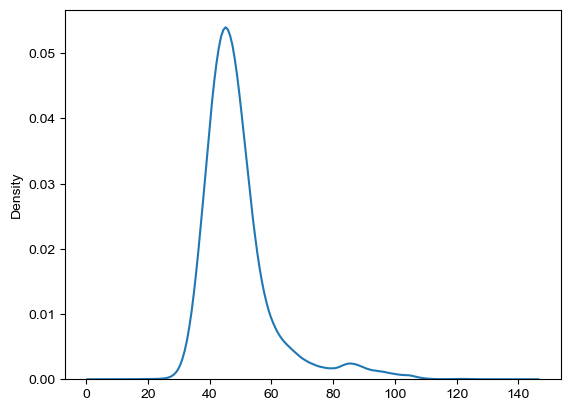

In [ ]:
fig, ax = plt.subplots()

idxs = np.triu_indices(n=5000, k=1)
dists = dists_df.values[idxs[0], idxs[1]]

sns.kdeplot(x=dists, ax=ax, color='dimgray')
ax.set_ylabel('density')
ax.set_xlabel('pairwise distance')

plt.show()


In [ ]:
# ncbi_genome_metadata_df = load_ncbi_genome_metadata()

# fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(2 * 6.2, 4.8), width_ratios=[0.4, 0.6])

# counts, bins, _ = ax_a.hist(ncbi_genome_metadata_df.gc_percent, bins=25, width=2, edgecolor='black', color='lightgray')
# ax_a.set_ylabel('density')
# ax_a.set_xlabel('GC percent')

# level = 'phylum'
# y = ncbi_genome_metadata_df.groupby(level).gc_percent.mean().values # .sort_values(ascending=True)
# x = ncbi_genome_metadata_df.groupby(level).apply(len, include_groups=False).values # .sort_values(ascending=True)
# y_err = ncbi_genome_metadata_df.groupby(level).apply(lambda df : df.gc_percent.std() / np.sqrt(len(df)), include_groups=False) # .loc[y.index]
# ax_b.errorbar(x, y, yerr=y_err, ls='', lw=0.7, capsize=2, color='black')
# ax_b.scatter(x, y, color='black', s=5)

# phyla = ncbi_genome_metadata_df.groupby(level).first().index
# ax_b.scatter(x[phyla == 'Campylobacterota'], y[phyla == 'Campylobacterota'], facecolor='none',linewidths=1.5, edgecolors='seagreen', s=100, zorder=1000)
# ax_b.scatter(x[phyla == 'Planctomycetota'], y[phyla == 'Planctomycetota'], facecolor='none', linewidths=1.5, edgecolors='seagreen', s=100, zorder=1000)
# ax_b.scatter(x[phyla == 'Deinococcota'], y[phyla == 'Deinococcota'], facecolor='none', linewidths=1.5, edgecolors='seagreen', s=100, zorder=1000)

# ax_b.set_xscale('log')
# ax_b.set_xlabel(f'log({level} size)')
# ax_b.set_ylabel('GC percent')

# plt.show()

In [ ]:
# # Start by selecting a few phyla in a reasonable size range with varying GC contents.
# def sample(genome_metadata_df:pd.DataFrame, min_phylum_size:int=90, max_phylum_size:int=200):

#     phylum_sizes = genome_metadata_df.groupby('phylum').apply(len, include_groups=False)
#     phylum_sizes = phylum_sizes[(phylum_sizes > min_phylum_size) & (phylum_sizes < max_phylum_size)]

#     genome_metadata_df = genome_metadata_df[genome_metadata_df.phylum.isin(phylum_sizes.index)]
    
#     phylum_gc_percent = genome_metadata_df.groupby('phylum').gc_percent.mean() 
#     phylum_gc_percent = phylum_gc_percent.sort_values(ascending=True)
    
#     phyla = dict()
#     phyla['low_gc_content'] = phylum_gc_percent.index[0]
#     phyla['med_gc_content'] = phylum_gc_percent.index[len(phylum_gc_percent) // 2]
#     phyla['high_gc_content'] = phylum_gc_percent.index[-1]

#     print('Low-GC content phylum:', phyla['low_gc_content'])
#     print('Medium-GC content phylum:', phyla['med_gc_content'])
#     print('High-GC content phylum:', phyla['high_gc_content'])

#     genome_ids = {category:genome_metadata_df.index[genome_metadata_df.phylum == phylum] for category, phylum in phyla.items()}
#     return genome_ids

# genome_ids = sample(ncbi_genome_metadata_df)

# ncbi = NCBIDatasets(genome_dir='../data/genomes', gbff_dir='../data/proteins/ncbi')
# ncbi.run(genome_ids=genome_ids['low_gc_content'], metadata_only=False)

In [ ]:
# genome_metadata_df = list()
# for category, genome_ids_ in genome_ids.items():
#     df = ncbi_genome_metadata_df.loc[genome_ids_, :].copy()
#     df['gc_percent_category'] = category
#     genome_metadata_df.append(df)
# genome_metadata_df = pd.concat(genome_metadata_df)
# genome_metadata_df.to_csv('../data/genome_metadata.csv')

In [ ]:
# genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)
# genome_metadata_df = genome_metadata_df[genome_metadata_df.annotation_pipeline.str.contains('PGAP')]
# campylobacterota_genome_ids = genome_metadata_df[genome_metadata_df.phylum == 'Campylobacterota'].index

# build(campylobacterota_genome_ids, labeled=True, output_path='../data/campylobacterota_dataset_labeled.csv', max_length=2000)
# build(campylobacterota_genome_ids, labeled=False, output_path='../data/campylobacterota_dataset.csv', max_length=2000)

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import balanced_accuracy_score
# from sklearn.preprocessing import StandardScaler

# class BenchmarkClassifier():

#     def __init__(self, feature_col:str='query_length'):

#         self.model = LogisticRegression(class_weight='balanced', C=1) # , multi_class='multinomial') 
#         self.scaler = StandardScaler()
#         self.feature_col = feature_col

#     def predict(self, df:pd.DataFrame, include_outputs:bool=True):
#         X = df[[self.feature_col]].values
#         X = self.scaler.transform(X)
#         model_labels = self.model.predict(X)
#         model_outputs = self.model.predict_proba(X)

#         return model_labels if (not include_outputs) else (model_labels, model_outputs)

#     def fit(self, df:pd.DataFrame):
#         X, labels = df[[self.feature_col]].values, df['label'].values
#         X = self.scaler.fit_transform(X)
#         self.model.fit(X, labels)

# model = BenchmarkClassifier()
# model.fit(train_df)

# df = test_df[['label', 'query_length']].copy()
# df['model_label'], outputs = model.predict(test_df, include_outputs=True)
# df['model_output_0'], df['model_output_1'] = outputs[:, 0].ravel(), outputs[:, 1].ravel()

# print('Balanced accuracy:', balanced_accuracy_score(df.label.values, df.model_label.values))
# print('Precision (class 0):', precision(df, class_=0))
# print('Recall (class 0):', recall(df, class_=0))
# print('Number of false negatives:', ((df.label == 1) & (df.model_label == 0)).sum())


# confusion_matrix = np.where((df.model_label == 1) & (df.label == 0), 'false positive', '')
# confusion_matrix = np.where((df.model_label  == 1) & (df.label == 1), 'true positive', confusion_matrix)
# confusion_matrix = np.where((df.model_label == 0) & (df.label == 1), 'false negative', confusion_matrix)
# confusion_matrix = np.where((df.model_label  == 0) & (df.label == 0), 'true negative', confusion_matrix)
# df['confusion_matrix'] = confusion_matrix

# benchmark_fn = df[df.confusion_matrix == 'false negative'].index
# fn = pred_df[pred_df.confusion_matrix == 'false negative'].index
# np.intersect1d(fn, benchmark_fn)

In [ ]:
# There still seems to be something wrong with the training data, perhaps I am still misclassifying the spurious sequences?
# It is possible my "in-frame" check is wrong, it's possible I should only see if either edge is a multiple of 3 base pairs away, 
# as opposed to both.

# It seems as though 684 of the sequences flagged as spurious have an overlap length of 0, so maybe I should be counting those as intergenic?
# Ok, so I think because of how frequent gene overlap is, I should be allowing some (considering genes with less than a certain amount of overlap to be intergenic)
# I should also be very conservative, i.e. allow a comparatively large amount of overlap. 
# https://pmc.ncbi.nlm.nih.gov/articles/PMC525685/ 
